In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chisquare
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
# sharper plots
%config InlineBackend.figure_format = 'retina'

import plotly.express as px
import os, re

Перед вами данные взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней. И таблица с характеристиками рекламных клиентов (те, кто разместил эти объявления).

ads_data.csv – данные взаимодействий с рекламными объявлениями
date – дата
time – время
event – действие (просмотр/клик)
platform – платформа
ad_id – id объявления
client_union_id – id рекламного кабинета
campaign_union_id – id рекламной кампании
ad_cost_type – тип оплаты
ad_cost – цена
has_video – есть ли видео
target_audience_count – размер аудитории

ads_clients_data.csv – характеристики рекламных клиентов
date – дата
client_union_id – id рекламного кабинета
community_id – id сообщества
create_date – дата создания рекламного клиента

In [4]:
ads_data    = pd.read_csv("E:\\.ML\\[Анатолий Карпов] [Stepic] Data Analytic Часть 1\\6\\Задания\\Минипроект\\ads\\ads_data.csv")
ads_clients = pd.read_csv("E:\\.ML\\[Анатолий Карпов] [Stepic] Data Analytic Часть 1\\6\\Задания\\Минипроект\\ads\\ads_clients_data.csv")

In [5]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [6]:
ads_clients.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


#### Разберемся с распределением количества показов и кликов. Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).

In [47]:
ads_per_id_and_event = ads_data.groupby(['ad_id','event'], as_index=False)\
                            .agg({"time":"count"})

In [48]:
pivot_ads_event = ads_per_id_and_event.pivot(columns='event', index='ad_id', values='time').fillna(0)

In [49]:
pivot_ads_event.mean().round()

event
click    113.0
view     923.0
dtype: float64

#### Нарисуйте график распределения показов на объявление за весь период.

In [67]:
views_on_ads = ads_per_id_and_event.query('event == "view"')

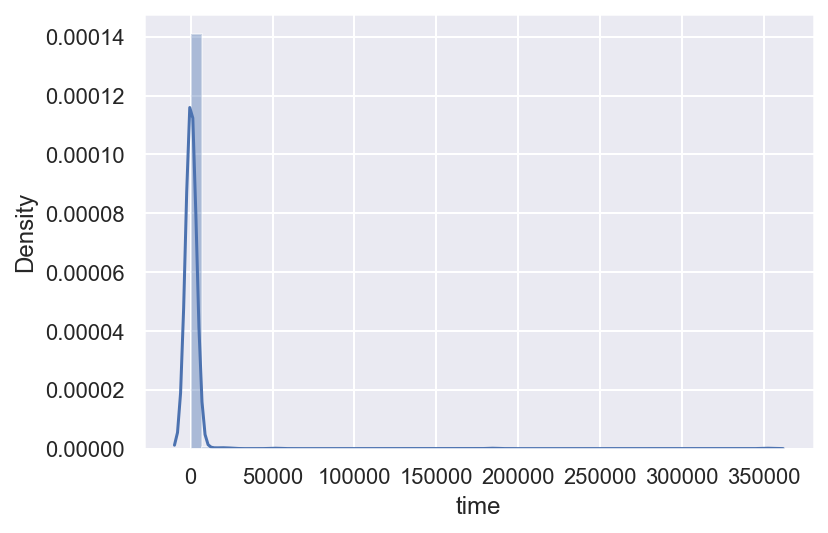

In [70]:
sns.distplot(views_on_ads.time);

In [71]:
views_on_ads.time.describe()

count       956.000000
mean        931.822176
std       13006.492754
min          10.000000
25%          36.000000
50%          84.000000
75%         209.250000
max      351802.000000
Name: time, dtype: float64

Тк тут слишком много редко встречающихся больших значений, можно взять логарифм от данных

In [81]:
sns.set(font_scale=2, style='whitegrid', rc={'figure.figsize':(8,6)})

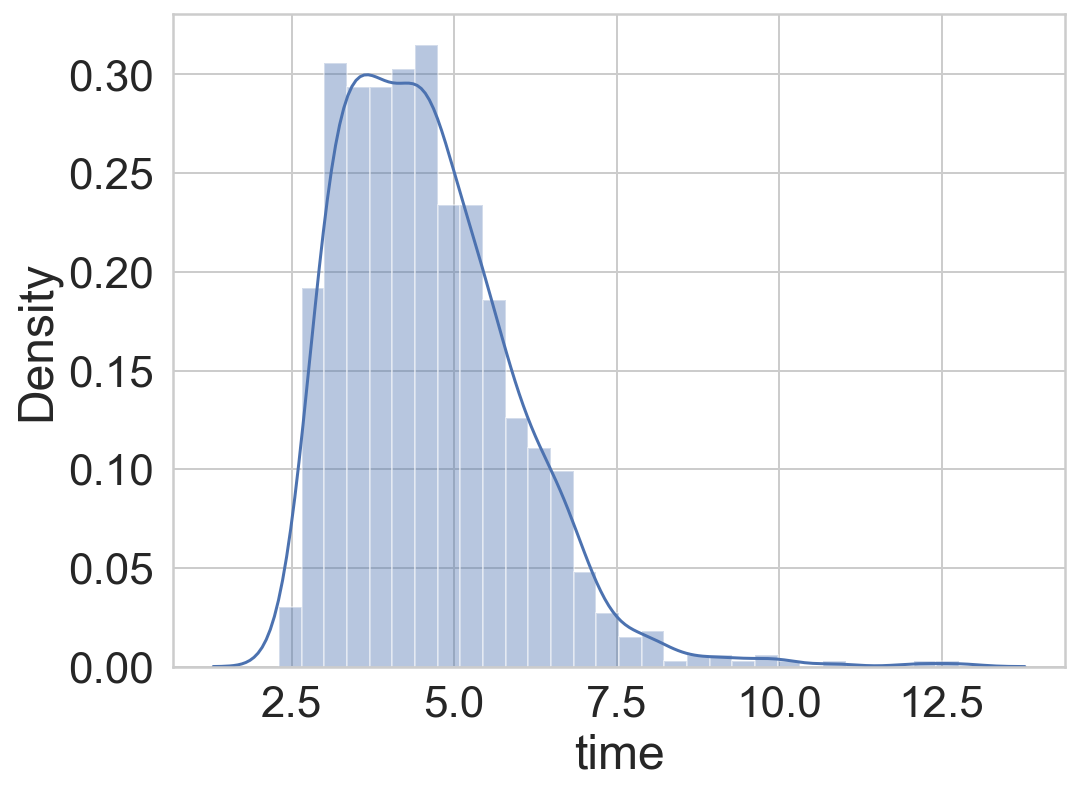

In [82]:
sns.distplot(np.log(views_on_ads.time));

In [74]:
np.log(views_on_ads.time).describe()

count    956.000000
mean       4.597903
std        1.330069
min        2.302585
25%        3.583519
50%        4.430817
75%        5.343528
max       12.770824
Name: time, dtype: float64

#### А теперь давайте посчитаем скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?

In [95]:
views_on_ads#.rolling(2, on='ad_id').mean()

,ad_id,event,time
1,2,view,101
3,3,view,184
5,1902,view,41
6,2064,view,35
8,2132,view,58
...,...,...,...
1475,122004,view,100
1476,122013,view,156
1477,122023,view,68
1479,122031,view,138


#### Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем.

#### *Напишите функцию, которая найдет проблемное объявление (с наибольшим/наименишим количеством показов) в день, в который была замечена самая большая по модулю аномалия.

#### *Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.

#### *Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней. Ответ дайте в процентах и округлите до сотых. (Фильтровать нужно по значению в формате pd.Timedelta(365, unit='d'))

#### *Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30. Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков для метода pd.cut – [0, 30, 90, 180, 365]

#### *А теперь давайте выведем на интерактивный график эти категории с количеством уникальных клиентов в них.